In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import random

from scipy.integrate import quad
from scipy import constants
from scipy import interpolate

from astropy.cosmology import Planck18
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.table import Table

from multiprocessing import Pool
import time
from tqdm import tqdm

###########################
# CONSTANTS
###########################
H0GLOB= 67#69.32#67.9 #69
Om0GLOB=0.319
Xi0Glob =1.
clight = 2.99792458* 10**5#km/s
cosmoglob = Planck18
cosmofast = FlatLambdaCDM(H0=H0GLOB, Om0=Om0GLOB)
H0=cosmoglob.H(0).value
h=H0GLOB/100
#geometrization of masses
Msun=(1.98892)*(10**30)
solarmass_to_m=(constants.G*Msun)/((constants.c)**2)#G/c^2
Mpc_to_m=3.08567758128*(10**22) #this will be used later
#-------miscellanea-----------------------
xmax=100
ymax=100
zmax=100
half_box_size=2

Npoints=1000
Sigma=10
#----------------from distances to redshift----------------------
zz=np.linspace(0,10,50000)
distinterpol=(1+zz)*cosmofast.comoving_distance(zz).value
z_of_dl=interpolate.interp1d(distinterpol,zz)
distinterpol_dc=cosmofast.comoving_distance(zz).value
z_of_dc=interpolate.interp1d(distinterpol_dc,zz)

In [2]:
#-----------rejection-stuff------------
def sample(g,xmin,xmax):
    x = np.linspace(xmin,xmax,1000000)
    y = g(x)                        # probability density function, pdf
    cdf_y = np.cumsum(y)            # cumulative distribution function, cdf
    cdf_y = cdf_y/cdf_y.max()       # takes care of normalizing cdf to 1.0
    inverse_cdf = interpolate.interp1d(cdf_y,x,fill_value="extrapolate")# this is a function
    #inverse_cdf = np.interp(0,cdf_y,x) #this works but it is not a function
    return inverse_cdf
def return_samples(f,xmin,xmax,N=1000000):
    # let's generate some samples according to the chosen pdf, f(x)
    uniform_samples = random(int(N))       
    required_samples = sample(f,xmin,xmax)(uniform_samples)
    return required_samples

In [3]:
#------------1/8 of master catalogue------------#
def NewPlacer(redslice):
    one_phi=np.random.choice(temp_phi)
    one_theta=np.random.choice(temp_theta)
    one_zeta=np.random.choice(redslice)
    df_candidates=df
    #Create a list of possible host
    k=1
    #print(df_candidates.empty)
    while True:
        df_candidates=df[(df['ra_gal']>one_phi-k*ang_epsilon) & (df['ra_gal']<one_phi+k*ang_epsilon)]
        df_candidates=df_candidates[(df_candidates['dec_gal']>one_theta-k*ang_epsilon) & (df_candidates['dec_gal']<one_theta+k*ang_epsilon)]
        df_candidates=df_candidates[(df_candidates['true_redshift_gal']>one_zeta-k*red_epsilon) & (df_candidates['true_redshift_gal']<one_zeta+k*red_epsilon)]
        if df_candidates.empty:
            k=k+1 
        if (df_candidates.empty==False):
            break
    #Raul: given a point in space, find nearest N host given the list
    df_candidates=df_candidates.reset_index(drop=True)
    if (df_candidates.shape[0]==1):
        unique_host=df_candidates.head(1)

    if (df_candidates.shape[0]>1):
        parameterdist=np.zeros(df_candidates.shape[0])
        for index, row in df_candidates.iterrows():
            parameterdist[index]=np.sqrt((row['dec_gal']-one_theta)**2+(row['ra_gal']-one_phi)**2+(row['true_redshift_gal']-one_zeta)**2)
        df_candidates['parameterdist']=parameterdist
        df_candidates=df_candidates.sort_values(["parameterdist"], ascending=True) 
        unique_host=df_candidates.head(1)
    #Now, for each value of angles and z, we select a single host
    x_host=unique_host['x_gal'].values[0]/h
    y_host=unique_host['y_gal'].values[0]/h
    z_host=unique_host['z_gal'].values[0]/h
    pp=np.random.uniform(0,2*np.pi)
    costt=np.random.uniform(-1,1)
    tt=np.arccos(costt)
    r=np.random.choice(two_point_radii_cutted)
    #distcut=0.1
    #while True:
    #    r=np.random.choice(two_point_radii)
    #    if(r>=distcut):
    #        break
    xx=r*np.sin(tt)*np.cos(pp)/h
    yy=r*np.sin(tt)*np.sin(pp)/h
    zz=r*np.cos(tt)/h
    xDS=x_host+xx
    yDS=y_host+yy
    zDS=z_host+zz
    Redshift_host=unique_host['true_redshift_gal'].values[0]
    dsdistnoh=np.sqrt(xDS**2+yDS**2+zDS**2)#real comoving distance
    Redshift_DS=z_of_dc(dsdistnoh)
    return(x_host,y_host,z_host,Redshift_host,xDS,yDS,zDS,Redshift_DS)
def spoiler(redshift_positions,number_of_DS):
    Host_x_todf=[]
    Host_y_todf=[]
    Host_z_todf=[]
    Host_redshift_todf=[]
    DS_x_todf=[]
    DS_y_todf=[]
    DS_z_todf=[]
    DS_redshift_todf=[]
    retdf=pd.DataFrame()
    print('I am Working')
    for i in range (len(redshift_positions)-1):
        zmin=redshift_positions[i]
        zmax=redshift_positions[i+1]
        num=int(number_of_DS[i])
        print('i={}'.format(i))
        for k in range(num):
            #if k==0:
            #    print(k)
            #if (k%100==0):
            #    print(k)
            tempred=temp_z_values[(temp_z_values>=zmin)&(temp_z_values<=zmax)]
            flybie=NewPlacer(tempred)
            Host_x_todf=np.append(Host_x_todf,flybie[0])
            Host_y_todf=np.append(Host_y_todf,flybie[1])
            Host_z_todf=np.append(Host_z_todf,flybie[2])
            Host_redshift_todf=np.append(Host_redshift_todf,flybie[3])
            DS_x_todf=np.append(DS_x_todf,flybie[4])
            DS_y_todf=np.append(DS_y_todf,flybie[5])
            DS_z_todf=np.append(DS_z_todf,flybie[6])
            DS_redshift_todf=np.append(DS_redshift_todf,flybie[7])
    data=[Host_x_todf,Host_y_todf,Host_z_todf,Host_redshift_todf,DS_x_todf,DS_y_todf,DS_z_todf,DS_redshift_todf]
    #print(len(Host_x_todf),len(Host_y_todf),len(Host_y_todf),len(Host_redshift_todf),len(DS_x_todf),len(DS_y_todf),len(DS_z_todf),len(DS_redshift_todf))
    mycol=['Host_x','Host_y','Host_z','Host_redshift','DS_x','DS_y','DS_z','DS_redshift']
    for n in range(len(mycol)):
        retdf[mycol[n]]=data[n]
    return retdf

In [ ]:
#----------------Other columns-----------------------------
#cos_i=np.random.uniform(-1,1,EVA00.shape[0])
def primary_mass(m):
    if (m<40):
        massprob=lambda m: m**(-1.5)
        ret=massprob(m)
        return ret
    if ((m>=40)*(m<80)):
        massprob=lambda m: ((40)**(-1.5))*(40**5)*m**(-5)
        ret=massprob(m)
        return ret
    if ((m>=80)*(m<=120)):
        massprob=lambda m: m*0
        ret=massprob(m)
        return ret
    if (m>120):
        massprob=lambda m: 1/m
        ret=massprob(m)
        return ret
    return
#---------This is the correct way to extract from a piecewise distribution!
m = np.linspace(5,10000,10000000)
lowm=np.linspace(5,80,100000)
highm=np.linspace(120,10000,100000)
f1 = lambda m: m**(-1.5)
f2 = lambda m: ((40)**(-1.5))*(40**5)*m**(-5)
f3 = lambda m: m*0
f4 = lambda m: (((40)**(-1.5))*(40**5)*120**(-5))*(120)*1/m
fx = np.piecewise(m, [(m<40), (m>=40) * (m<80), (m>=80) * (m<120),(m>=120)], [f1,f2,f3,f4])
Mass_dist=interpolate.interp1d(m,fx,fill_value="extrapolate") #distribution as a function
f_low=np.piecewise(lowm, [(lowm<40), (lowm>=40) * (lowm<80)], [f1,f2])
low_mass_dist=interpolate.interp1d(lowm,f_low,fill_value="extrapolate")
def secondary_mass(m):
    if (m<=80):
        while True:
            q=np.random.choice(arr_low_q)
            m2=m*q
            if (m2>1.2):
                break
    if (m>=119):
        while True:
            q=np.random.choice(arr_high_q)
            m2=m*q
            if (m2>1.2):
                break
    return q,m2

In [ ]:
arrlow=return_samples(low_mass_dist,5,80,10000000)
arrhigh=return_samples(f4,120,10000,10000000)

In [ ]:
#primarymasses=np.zeros(EVA00.shape[0])
#for i in range(dscat.shape[0]):
#    primarymasses[i]=np.random.choice(MassValues)
#EVA00['M1']=primarymasses
#arrq=np.zeros(dscat.shape[0])
#secondarymasses=np.zeros(dscat.shape[0])
#for i in range(dscat.shape[0]):
#    arrq[i],secondarymasses[i]=secondary_mass(primarymasses[i])
low_q=lambda q: 1/q
high_q=lambda q: np.sqrt(q)
arr_low_q=return_samples(low_q,0.1,1,10000000)
arr_high_q=return_samples(high_q,0.1,1,10000000)
#MassValues=return_samples(vprimary_mass,5,10000,10000000)

In [ ]:
#------------read the flagship-------------------------------------
dat = Table.read('11536.fits', format='fits')
df = dat.to_pandas()#all good, is an only text fits
print(df.columns)
print(df.shape)

In [ ]:
#############################################################################################
###############--------DS-spatial-coordinates-###############################################
#############################################################################################

#Restrict the angular coordinate to be those of the flagship
phi_min=df.ra_gal.min()#*np.pi/180
phi_max=df.ra_gal.max()#*np.pi/180
theta_min=df.dec_gal.min()#*np.pi/180
theta_max=df.dec_gal.max()#*np.pi/180
#Restrict to the right redshift interval
z_min=df.true_redshift_gal.min()
z_max=df.true_redshift_gal.max()
#print('phi_min={}, phi_max={}, \ntheta_min={}, theta_max{}, \nz_min{}, z_max={}'
#      .format(phi_min,phi_max,theta_min,theta_max,z_min,z_max))
#ds_phi=np.random.uniform(0,phi_lim,500000)
ang_epsilon=0.1
red_epsilon=0.01
temp_phi=np.random.uniform(phi_min,phi_max,100000)#degrees
temp_theta=np.random.uniform(theta_min,theta_max,100000)#degrees
temp_z_values=np.loadtxt('redshift_MC.txt')
two_point_radii=np.loadtxt('two_point_radii.txt')
two_point_radii_cutted=np.loadtxt('two_point_radii_cutted.txt')
Numb_DS_of_z_int=np.loadtxt('Numb_DS_of_z_int.txt')
arr_of_int_lim=np.loadtxt('arr_of_int_lim.txt')

In [ ]:
z_min=df.true_redshift_gal.min()
z_max=df.true_redshift_gal.max()
print(z_min,z_max)

In [ ]:
#start_time = time.time()
#with Pool(35) as p:
#    EVA00=spoiler(arr_of_int_lim,Numb_DS_of_z_int)
#print("--- %s seconds ---" % ((time.time() - start_time)))

In [ ]:
#t = Table.from_pandas(EVA00)
#t.write('EVA00.fits', overwrite=True)

In [ ]:
effective_primary_masses=np.loadtxt('effective_primary_masses.txt')
orbital_inclination=np.loadtxt('cos_inclination.txt')
mass_ratio=np.loadtxt('mass_ratio.txt')
secondaryMasses=np.loadtxt('secondaryMasses.txt')
#psitosave=np.random.uniform(0,2*np.pi,dscat.shape[0])
#np.savetxt('allpsi.txt',psitosave)
psi=np.loadtxt('allpsi.txt')

In [ ]:
#cos_orbital_incl', 'M1', 'M2', 'q'
EVA00['cos_orbital_incl']=orbital_inclination
EVA00['M1']=effective_primary_masses
EVA00['M2']=secondaryMasses
EVA00['q']=mass_ratio
EVA00['psi']=psi

In [ ]:
#t = Table.from_pandas(EVA00)
#t.write('EVA01.fits', overwrite=True)
dat = Table.read('EVA01.fits', format='fits')
tempdf = dat.to_pandas()#all good, is an only text fits


In [ ]:
MassValues=return_samples(Mass_dist,5,10000,10**9)

In [ ]:
##################################################à#############
##########        TEST    ######################################
################################################################
dat = Table.read('EVA01.fits', format='fits')
dscat = dat.to_pandas()#all good, is an only text fits
print(dscat.columns)

In [ ]:
dscat.head()

In [ ]:
#-----------Primary Mass----------------------------------------
masstoprob=np.linspace(5,10000,100000)
norm=quad(Mass_dist,5,10000)[0]
realmasstest=dscat['M1']

In [ ]:
dscat.shape[0]

In [ ]:
plt.rcParams.update({'font.size': 23})
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

ax.plot(masstoprob,Mass_dist(masstoprob)/norm,label='ProbMass',color='r')
myhist=plt.hist(realmasstest,bins=1500,density=True)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Mass/Msun')
plt.ylabel('PDF')
plt.title('Mass Dist')
plt.yscale('log')
plt.xscale('log')
plt.savefig('primarymassdist.png')

In [ ]:
tempdf=dscat.loc[(dscat['M1'] >= 80) & (dscat['M1'] <= 90)]
tempdf.shape

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.rcParams.update({'font.size': 25})
#ax.plot(masstoprob,Mass_dist(masstoprob)/norm,label='ProbMass',color='r')
myhist=plt.hist(realmasstest,bins=np.logspace(np.log10(5),np.log10(10000),150))
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Mass/Msun')
plt.ylabel('PDF')
plt.title('Mass Dist')
plt.yscale('log')
plt.xscale('log')
plt.savefig('2P-dist.png')

In [ ]:
bins=np.logspace(np.log10(5),np.log10(10000),150)
primo=bins[1]-bins[0]
ultimo=bins[-1]-bins[-2]
binwhidt=(10000-5)/500
lowmass=dscat.loc[(dscat['M1'] >= 5) & (dscat['M1'] <= 5+binwhidt)]
highmass=dscat.loc[(dscat['M1'] >= 10000-binwhidt) & (dscat['M1'] <= 10000)]
print(lowmass.shape[0],highmass.shape[0])
print(highmass.shape[0]/lowmass.shape[0])
print(primo,ultimo)
loglowmass=dscat.loc[(dscat['M1'] >= 5) & (dscat['M1'] <= 5+primo)]
loghighmass=dscat.loc[(dscat['M1'] >= 10000-ultimo) & (dscat['M1'] <= 10000)]
print(loglowmass.shape[0],loghighmass.shape[0])
print(loghighmass.shape[0]/loglowmass.shape[0])

In [ ]:
#---------Mass Ratio-------------------------------------------
low_q=lambda q: 1/q
high_q=lambda q: np.sqrt(q)

In [ ]:
tempdf=dscat.loc[(dscat['M1'] >= 4) & (dscat['M1'] <= 90)]

In [ ]:
testlowq=tempdf['q']

In [ ]:
qtemp=np.linspace(0.1,1,100000)
tempnorm=quad(low_q,0.1,1)[0]
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.rcParams.update({'font.size': 25})
ax.plot(qtemp,low_q(qtemp)/tempnorm,label='Low ratio',color='r')
myhist=plt.hist(testlowq,bins='auto',density=True)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('mass ratio')
plt.ylabel('PDF')
plt.title('Mass Ratio')
plt.yscale('log')
plt.xscale('log')

In [ ]:
tempdf=dscat.loc[(dscat['M1'] >= 119)]
testhighq=tempdf['q']
qtemp=np.linspace(0.1,1,100000)
tempnorm=quad(high_q,0.1,1)[0]
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.rcParams.update({'font.size': 25})
ax.plot(qtemp,high_q(qtemp)/tempnorm,label='Low ratio',color='r')
myhist=plt.hist(testhighq,bins='auto',density=True)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('mass ratio')
plt.ylabel('Prob Density')
plt.title('Mass Ratio')
plt.yscale('log')
plt.xscale('log')

In [ ]:
dist_diff=np.zeros(dscat.shape[0])
temphostx=dscat['Host_x']
temphosty=dscat['Host_y']
temphostz=dscat['Host_z']
tempdsx=dscat['DS_x']
tempdsy=dscat['DS_y']
tempdsz=dscat['DS_z']
for i in range(dscat.shape[0]):
    dist_diff[i]=np.sqrt((temphostx[i]-tempdsx[i])**2+(temphosty[i]-tempdsy[i])**2+(temphostz[i]-tempdsz[i])**2)
    

In [ ]:
r0=5
gamma=0.2
rmin=0
distcut=0.1
rmax=10
#target function
r_dist= lambda r: (r/r0)**(gamma)

x = np.linspace(0.1,rmax,1000000)
tempnorm=quad(r_dist,distcut,rmax)[0]
plt.rcParams.update({'font.size': 23})
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.rcParams.update({'font.size': 25})
ax.plot(x,r_dist(x)/(tempnorm),label='Comulative rad',color='r')
#ax.plot(rtemp,r_dist(rtemp),label='',color='r')
myhist=plt.hist(dist_diff,bins='auto',density=True)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('distance from host Mpc')
plt.ylabel('PDF-shell')
plt.title('2P distribution on a shell')

plt.yscale('log')
plt.xscale('log')
#plt.savefig('2P-dist.png')

In [39]:
#---------------------Merging------------------------------
dat = Table.read('EVA02.fits', format='fits')
tomerge = dat.to_pandas()
hx=np.array(tomerge['Host_x'])
hy=np.array(tomerge['Host_y'])
hz=np.array(tomerge['Host_z'])
hred=np.array(tomerge['Host_redshift'])
dx=np.array(tomerge['DS_x'])
dy=np.array(tomerge['DS_y'])
dz=np.array(tomerge['DS_z'])
dred=np.array(tomerge['DS_redshift'])
rhost=np.zeros(tomerge.shape[0])
rds=np.zeros(tomerge.shape[0])
new_dx=np.zeros(tomerge.shape[0])
new_dy=np.zeros(tomerge.shape[0])
new_dz=np.zeros(tomerge.shape[0])
new_dred=np.zeros(tomerge.shape[0])
merged=np.zeros(tomerge.shape[0])

In [44]:
for i in tqdm(range(tomerge.shape[0])):
    rhost[i]=np.sqrt(hx[i]**2+hy[i]**2+hz[i]**2)
    rds[i]=np.sqrt(dx[i]**2+dy[i]**2+dz[i]**2)
    if (abs(rhost[i]-rds[i])<2):
        merged[i]=1
        dx[i]=hx[i]
        dy[i]=hy[i]
        dz[i]=hz[i]
        dred[i]=hred[i]
    else:
        merged[i]=0

100%|██████████| 515652/515652 [00:02<00:00, 213893.95it/s]


In [52]:
tomerge.drop('DS_x', inplace=True, axis=1)
tomerge.drop('DS_y', inplace=True, axis=1)
tomerge.drop('DS_z', inplace=True, axis=1)
tomerge.drop('DS_redshift', inplace=True, axis=1)
tomerge['merged']=flag

In [53]:
tomerge.insert(loc=4, column='DS_x', value=dx)
tomerge.insert(loc=5, column='DS_y', value=dy)
tomerge.insert(loc=6, column='DS_z', value=dz)
tomerge.insert(loc=7, column='DS_redshift', value=dred)

In [54]:
#t = Table.from_pandas(tomerge)
#t.write('EVA03.fits', overwrite=True)

In [55]:
tomerge.head(5)

,Host_x,Host_y,Host_z,Host_redshift,DS_x,DS_y,DS_z,DS_redshift,cos_orbital_incl,M1,M2,q,psi,SNR,Aproximant,merged
0,651.933995,402.188065,2806.954546,0.808803,651.933995,402.188065,2806.954546,0.808803,0.793474,10.569518,5.143687,0.486653,2.550917,47.566179,b'IMRPhenomD',1
1,1901.947841,477.181005,2147.676656,0.808301,1901.947841,477.181005,2147.676656,0.808301,-0.615400,26.536605,5.515256,0.207836,3.274064,94.996610,b'IMRPhenomD',1
2,792.327061,2056.292634,1873.462461,0.802654,796.891722,2051.491963,1868.765822,0.800800,0.228812,38.501322,29.412304,0.763930,3.479153,168.103360,b'IMRPhenomD',0
3,2566.548362,58.913997,1323.989640,0.801273,2571.261103,58.839892,1319.617234,0.802053,0.694977,14.085194,1.642785,0.116632,4.078907,70.825260,b'IMRPhenomD',0
4,1165.316454,2573.915761,575.600923,0.799466,1165.316454,2573.915761,575.600923,0.799466,-0.838562,5.332573,2.141039,0.401502,2.813217,89.006671,b'IMRPhenomD',1


In [2]:
#------------read the flagship-------------------------------------
dat = Table.read('EVA02.fits', format='fits')
cat = dat.to_pandas()#all good, is an only text fits
print(cat.columns)
print(cat.shape[0])
cat.head(3)

Index(['Host_x', 'Host_y', 'Host_z', 'Host_redshift', 'DS_x', 'DS_y', 'DS_z',
       'DS_redshift', 'cos_orbital_incl', 'M1', 'M2', 'q', 'psi', 'Aproximant',
       'SNR'],
      dtype='object')
515652


,Host_x,Host_y,Host_z,Host_redshift,DS_x,DS_y,DS_z,DS_redshift,cos_orbital_incl,M1,M2,q,psi,Aproximant,SNR
0,651.933995,402.188065,2806.954546,0.808803,651.933995,402.188065,2806.954546,0.808803,0.793474,10.569518,5.143687,0.486653,2.550917,b'IMRPhenomD',96.279798
1,1901.947841,477.181005,2147.676656,0.808301,1901.947841,477.181005,2147.676656,0.808301,-0.615400,26.536605,5.515256,0.207836,3.274064,b'IMRPhenomD',81.336203
2,792.327061,2056.292634,1873.462461,0.802654,796.891722,2051.491963,1868.765822,0.800800,0.228812,38.501322,29.412304,0.763930,3.479153,b'IMRPhenomD',114.008069


In [3]:
detected=cat[cat['SNR']>12]

In [4]:
detected.shape[0]/cat.shape[0]

0.8966027475894596

In [5]:
print(detected.columns)
print(detected.shape[0])
detected.head()

Index(['Host_x', 'Host_y', 'Host_z', 'Host_redshift', 'DS_x', 'DS_y', 'DS_z',
       'DS_redshift', 'cos_orbital_incl', 'M1', 'M2', 'q', 'psi', 'Aproximant',
       'SNR'],
      dtype='object')
462335


,Host_x,Host_y,Host_z,Host_redshift,DS_x,DS_y,DS_z,DS_redshift,cos_orbital_incl,M1,M2,q,psi,Aproximant,SNR
0,651.933995,402.188065,2806.954546,0.808803,651.933995,402.188065,2806.954546,0.808803,0.793474,10.569518,5.143687,0.486653,2.550917,b'IMRPhenomD',96.279798
1,1901.947841,477.181005,2147.676656,0.808301,1901.947841,477.181005,2147.676656,0.808301,-0.615400,26.536605,5.515256,0.207836,3.274064,b'IMRPhenomD',81.336203
2,792.327061,2056.292634,1873.462461,0.802654,796.891722,2051.491963,1868.765822,0.800800,0.228812,38.501322,29.412304,0.763930,3.479153,b'IMRPhenomD',114.008069
3,2566.548362,58.913997,1323.989640,0.801273,2571.261103,58.839892,1319.617234,0.802053,0.694977,14.085194,1.642785,0.116632,4.078907,b'IMRPhenomD',29.901415
4,1165.316454,2573.915761,575.600923,0.799466,1165.316454,2573.915761,575.600923,0.799466,-0.838562,5.332573,2.141039,0.401502,2.813217,b'IMRPhenomD',22.195059


In [11]:
rnd_detected=detected.sample(100000)

In [8]:
t = Table.from_pandas(detected)
t.write('EVA02_detected12_fiveyear.fits', overwrite=True)

In [5]:
#------------read the flagship-------------------------------------
dat03 = Table.read('EVA03.fits', format='fits')
cat03 = dat03.to_pandas()#all good, is an only text fits
print(cat03.columns)
print(cat03.shape[0])
cat03.head(3)

Index(['Host_x', 'Host_y', 'Host_z', 'Host_redshift', 'DS_x', 'DS_y', 'DS_z',
       'DS_redshift', 'cos_orbital_incl', 'M1', 'M2', 'q', 'psi', 'SNR',
       'Aproximant', 'merged'],
      dtype='object')
515652


,Host_x,Host_y,Host_z,Host_redshift,DS_x,DS_y,DS_z,DS_redshift,cos_orbital_incl,M1,M2,q,psi,SNR,Aproximant,merged
0,651.933995,402.188065,2806.954546,0.808803,651.933995,402.188065,2806.954546,0.808803,0.793474,10.569518,5.143687,0.486653,2.550917,47.566179,b'IMRPhenomD',1
1,1901.947841,477.181005,2147.676656,0.808301,1901.947841,477.181005,2147.676656,0.808301,-0.615400,26.536605,5.515256,0.207836,3.274064,94.996610,b'IMRPhenomD',1
2,792.327061,2056.292634,1873.462461,0.802654,796.891722,2051.491963,1868.765822,0.800800,0.228812,38.501322,29.412304,0.763930,3.479153,168.103360,b'IMRPhenomD',0


In [6]:
detected03=cat03[cat03['SNR']>12]
print(detected03.shape[0]/cat03.shape[0])

0.9418600141180486


In [7]:
cat.shape[0]-cat03.shape[0]

0

In [12]:
myz=detected['DS_redshift']

Text(0.5, 1.0, 'DS redshift distribution')

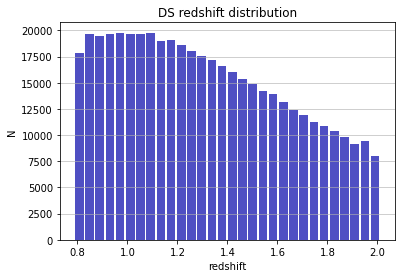

In [17]:
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=myz, bins=30,color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('redshift')
plt.ylabel('N')
plt.title('DS redshift distribution')



In [18]:
np.savetxt('RawNofEvents.txt',n)
np.savetxt('RawBins.txt',bins)